In [17]:
# Add scripts to path
import sys
sys.path.append('../scripts/')

# The use of the Mapper Algorithm to Analyse an Activity Model for a Series of MMP-12 Inhibitors

## Introduction

Here we will use the Mapper algorithm to analyse a model for the activity of a series of MMP-12 inhibitors.<br>
This work will study the series of MMP-12 inhibitors found in [[1](references)]. This series consists of a 50x50 matrix on a biaryl sulfonamide scaffold:
![biaryl_sulfonamide](images/MMP12/biaryl_sulfonamide.png)
Where $R_1$ and $R_2$ are 50 amino and borinic acids respectively.

## Loading in Data
1. Load in data in its entirety.
2. Select only the molecules where `pIC50_coded >= 0`
    1. These are the ones where activity was successfully measured
3. Create variable `active`, which is just binary for whether the molecule was active or not
4. Creation of integer variables representing class


<a id='references'>
## References
</a><br>
[1] Pickett, Stephen D., Green, Darren V.S., Hunt, David L., Pardoe, David A., Hughes, Ian; Automated Lead Optimization of MMP-12 Inhibitors using a Genetic Algorithm, _ACS Med. Chem. Lett._, __2011__, 2, 28-33 <br>

In [55]:
import pandas as pd
import numpy as np
import copy

MMP12_full = pd.read_csv('../data/MMP12/MMP12_full.csv')
MMP12_success = copy.deepcopy(MMP12_full.loc[MMP12_full['pIC50_coded'] >= 0])

n_molecules = len(MMP12_success)
MMP12_success['active'] = np.zeros(n_molecules, dtype=int)
MMP12_success.loc[MMP12_success['pIC50_coded'] > 0, 'active'] = 1

### Converstion of Atag and Btag into categoricals
MMP12_success['Aclass'] = [int(tag[1:]) for tag in MMP12_success['Atag']]
MMP12_success['Bclass'] = [int(tag[1:]) for tag in MMP12_success['Btag']]

## Calculation of Fingerprints

We will use the Morgan (radius 2) fingerprint. This is similar to the ECFP4 class of fingerprint.

In [16]:
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumAromaticRings, CalcNumRotatableBonds
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, GetMorganFingerprintAsBitVect, NumRotatableBondsOptions
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.GraphDescriptors import BertzCT
from rdkit.Chem import MolFromSmiles
from rdkit import DataStructs
from ipywidgets import FloatProgress, HBox, Label
from IPython.display import display

# Set up array to put fingerprints into
nBits = 512
useFeatures = False # Set this to true if we want to create fingerprints analogous to FCFP rather than ECFP
r = 2
fp_arr = np.zeros((n_molecules, nBits))

# Set up progress bar
progressbar = FloatProgress(min=0, max=n_molecules, bar_style='success')
progressbox = HBox([Label('Calculation Progress'), progressbar])
display(progressbox)

for smiles_i, smiles in enumerate(MMP12_success['Smiles']):
    
    # Create Molecule Object
    molecule = MolFromSmiles(smiles)
    
    ### Fingerprint calculation
    fingerprint = GetMorganFingerprintAsBitVect(molecule, r, nBits=nBits, useFeatures=useFeatures)
    
    #Put it into the fingerprint array
    arr = np.zeros((1,nBits),dtype='bool')
    DataStructs.ConvertToNumpyArray(fingerprint,arr)
    fp_arr[smiles_i] = arr
    
    # Tick up progressbar
    progressbar.value += 1

## Calculation of Image Tooltips

We will use the utility located in `../scripts/tooltip_utils.py` for this purpose

In [83]:
from rdkit.Chem import Draw
import io
import base64
import numpy as np
from scipy.misc import toimage, imsave, imresize

### THIS FUNCTION TECHNICALLY APPEARS IN SCRIPTS --- We put it here in full.

def smi2image(smiles, size=300):
    """Turn a smiles string into an image"""
    molecule = MolFromSmiles(smiles)
    return Draw.MolToImage(molecule, size=[size,size])

# Set up progress bar
progressbar = FloatProgress(min=0, max=n_molecules, bar_style='success')
progressbox = HBox([Label('Calculation Progress'), progressbar])
display(progressbox)

tooltips = []
for smiles_i, smiles in enumerate(MMP12_success['Smiles']):
    output = io.BytesIO()
    img = toimage(smi2image(smiles))
    img.save(output, format='PNG')
    contents = output.getvalue()
    img_encoded = base64.b64encode(contents)
    img_tag = """<p>
                 <div style="width:300px;
                            height:300px;
                            overflow:hidden;
                            float:left;
                            position:relative;">
                 <img src="data:image/png;base64,%s" style="position:absolute; top:0; right:0;
                                                            width: 300px; height: 300px;" />
                 </div>
                 </p>""" % (img_encoded.decode('utf-8'))
    tooltips.append(img_tag)
    progressbar.value += 1
tooltips = np.array(tooltips)

## Distribution of Tanimoto Distances

We only have around 1900 molecules so we can use the distance matrix in full

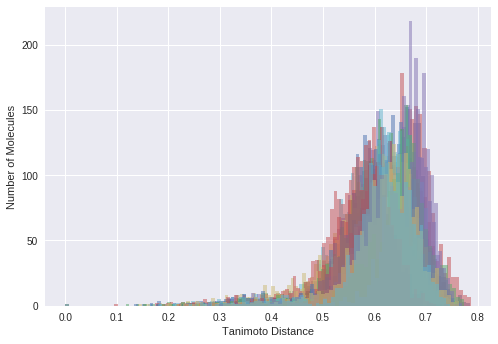

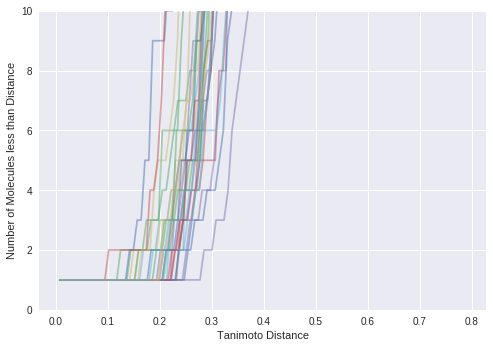

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings(action='ignore')

dist_mat = pairwise_distances(fp_arr, metric='jaccard')

n_samples = 30

molecule_indices = np.arange(n_molecules)

# Plotting objects
hist = plt.figure()
histax = hist.add_subplot(111)
cumsum = plt.figure()
cumsumax = cumsum.add_subplot(111)

np.random.seed(42)
for sample_n in range(n_samples):
    choice_molecule = np.random.choice(molecule_indices)
    histvals = histax.hist(dist_mat[choice_molecule].flatten(), bins=100, normed=False, alpha=0.5)
    
    cumsumvals = histvals[0].cumsum()
    cumsumax.plot(histvals[1][1:],cumsumvals, alpha=0.5)

n_nearest_cutoff = 10
cumsumax.set_ylim([0,n_nearest_cutoff])
cumsumax.set_xlabel('Tanimoto Distance')
cumsumax.set_ylabel('Number of Molecules less than Distance')
histax.set_xlabel('Tanimoto Distance')
histax.set_ylabel('Number of Molecules')
plt.show()

## Creation of Model

We're going to build a model for the activity of this data set. We will then use the OoB decision function for our lens

In [86]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, oob_score=True, max_features='log2')
model.fit(fp_arr, MMP12_success['active'])

prob_class = model.oob_decision_function_
pred_class = prob_class.argmax(axis=1)

# Creation of MDS

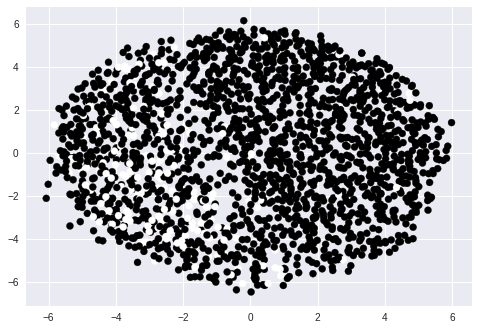

In [54]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric='jaccard')
mds_coords = mds.fit_transform(fp_arr)

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=MMP12_success['active'])
plt.show()

## Mapper - FiFa Lens

### Creation of Lens
$f(x) = (MDS_1, p_{max}, p_{true}, c_{true})$

In [68]:
fifa_lens = np.zeros((n_molecules, 4))

fifa_lens[:,0] = mds_coords[:,0]
fifa_lens[:,1] = prob_class.max(axis=1)
fifa_lens[:,3] = MMP12_success['active']

for n in range(n_molecules):
    fifa_lens[n,2] = prob_class[n,int(fifa_lens[n,3])]

### Mapper

In [89]:
import kmapper as km
from sklearn.cluster import DBSCAN

#### MAPPER HYPERPARAMETERS
n_cubes = [20,2,2,2]
perc_overlap = 0.2
cover = km.cover.Cover(n_cubes, perc_overlap)

eps = 0.4 # Too high and you basically are just creating a network representation of the lens projection
          # too low and you find most points are isolated
min_samples = 2 # This should be set low *enough* such that we actually get clusters with DBSCAN
metric = 'jaccard'
clusterer = DBSCAN(metric=metric, eps=eps, min_samples=min_samples, n_jobs=1)

### RANDOM SEED - useful for stochastic clustering method
random_seed = 42
np.random.seed(random_seed)

### MAPPER
mapper = km.KeplerMapper(verbose=1)
network = mapper.map(lens=fifa_lens,
                     X=fp_arr,
                     clusterer=clusterer,
                     cover=cover,
                     precomputed=False)
### VISUALISATION
_ = mapper.visualize(network,
                 title='MMP12: FiFa lens',
                 color_function=fifa_lens[:,2],
                 path_html='./networks/MMP12/fifa_network.html',
                 custom_tooltips = tooltips,
                 custom_meta={'Color': 'Probability of predicting the correct class'})


KeplerMapper()
Mapping on data shaped (1880, 512) using lens shaped (1880, 4)

Creating 160 hypercubes.

Created 126 edges and 121 nodes in 0:00:00.510868.
Wrote visualization to: ./networks/MMP12/fifa_network.html


## Mapper LiFa Lens

### Creation of Lens

$f(x) = (MDS_1, MDS_2, c_{true}, c_{pred})$

In [90]:
lifa_lens = np.zeros((n_molecules, 4))

lifa_lens[:,0] = mds_coords[:,0]
lifa_lens[:,1] = mds_coords[:,1]
lifa_lens[:,2] = MMP12_success['active']
lifa_lens[:,3] = pred_class

### Mapper

In [91]:
import kmapper as km
from sklearn.cluster import DBSCAN

#### MAPPER HYPERPARAMETERS
n_cubes = [20,20,2,2]
perc_overlap = 0.2
cover = km.cover.Cover(n_cubes, perc_overlap)

eps = 0.4 # Too high and you basically are just creating a network representation of the lens projection
          # too low and you find most points are isolated
min_samples = 2 # This should be set low *enough* such that we actually get clusters with DBSCAN
metric = 'jaccard'
clusterer = DBSCAN(metric=metric, eps=eps, min_samples=min_samples, n_jobs=1)

### RANDOM SEED - useful for stochastic clustering method
random_seed = 42
np.random.seed(random_seed)

### MAPPER
mapper = km.KeplerMapper(verbose=1)
network = mapper.map(lens=fifa_lens,
                     X=fp_arr,
                     clusterer=clusterer,
                     cover=cover,
                     precomputed=False)
### VISUALISATION
_ = mapper.visualize(network,
                 title='MMP12: LiFa lens',
                 color_function=fifa_lens[:,2],
                 path_html='./networks/MMP12/lifa_network.html',
                 custom_tooltips = tooltips,
                 custom_meta={'Color': 'Probability of predicting the correct class'})


KeplerMapper()
Mapping on data shaped (1880, 512) using lens shaped (1880, 4)

Creating 1600 hypercubes.

Created 124 edges and 194 nodes in 0:00:00.881299.
Wrote visualization to: ./networks/MMP12/lifa_network.html
